In [ ]:
using Revise  # auto reload

includet("State_Space_Model.jl")
using .state_space_model

includet("Kalman.jl")
using .kalman

includet("MCMC.jl")
using .MCMC

using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions
using Plots


In [2]:
# Parameters in θ
θ_elements = ["σ²_ε_y", "σ²_η_y", "σ²_ε_π", "σ²_η_π"]

n_params = length(θ_elements)

# List of prior distributions (all uniform for now).
prior_distributions = (
    "uniform", # \sigma²_ε, y
    "uniform", # \sigma²_ξ, y
    "uniform", # \sigma²_κ, y
    "uniform", # \sigma²_ε, π
)

# matrix of prior hyperparameters.
prior_hyperparameters = [ 
    0.0 1.1; # \sigma²_ε, y
    0.0 1.1; # \sigma²_ξ, y
    0.0 1.1; # \sigma²_κ, y
    0.0 1.1; # \sigma²_ε, π
]


# Create the support matrix in the same way.
support = [
    0.0 1.1; # \sigma²_ε, y
    0.0 1.1; # \sigma²_ξ, y
    0.0 1.1; # \sigma²_κ, y
    0.0 1.1; # \sigma²_ε, π
]

# Combine into a named tuple
prior_info = (
    support = support,
    distributions = prior_distributions,
    parameters = prior_hyperparameters,
)



#States in α
α_elements = [
    "u_t^y", 
    "u_t^π"
]


# True parameters
σ²_ε_y = 0.5
σ²_ξ_y = 0.5
σ²_κ_y = 0.5
σ²_ε_π = 0.5




θ_true = [σ²_ε_y, σ²_ξ_y, σ²_κ_y, σ²_ε_π]

# cycle_order
cycle_order = 1

1

In [3]:
Z,H,T,R,Q,P_diffuse = state_space(θ_true, cycle_order, [1,1])
println("Z = ", Z)
println("H = ", H)
println("T = ", T)
println("R = ", R)
println("Q = ", Q)
println("P_diffuse = ", P_diffuse)

# Print shapes
println("Z shape: ", size(Z))
println("H shape: ", size(H))
println("T shape: ", size(T))
println("R shape: ", size(R))
println("Q shape: ", size(Q))
println("P_diffuse shape: ", size(P_diffuse))

Z = [1.0 0.0; 0.0 1.0]
H = [0.5 0.0; 0.0 0.5]
T = [1.0 0.0; 0.0 1.0]
R = [1.0 0.0; 0.0 1.0]
Q = [0.5 0.0; 0.0 0.5]
P_diffuse = [0.0 0.0; 0.0 0.0]
Z shape: (2, 2)
H shape: (2, 2)
T shape: (2, 2)
R shape: (2, 2)
Q shape: (2, 2)
P_diffuse shape: (2, 2)


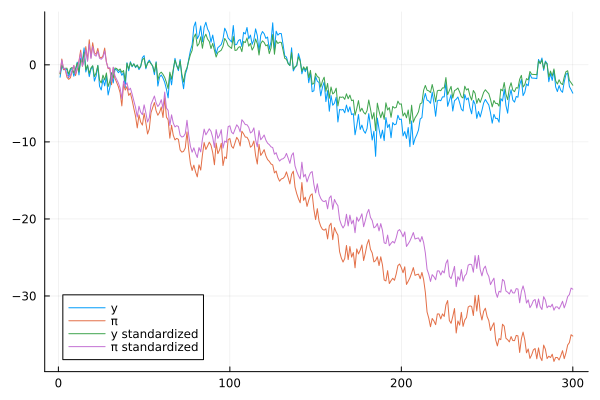

[1.3887109221625191, 1.2089589652853654]


2×2 Matrix{Bool}:
 1  0
 0  1

In [4]:
n_obs = 300

#simulate data
obs, α = simulate_data(θ_true, cycle_order, n_obs)

obs_std, σʸ = standardize_data(obs)
println(σʸ)

# obs_std = obs
# σʸ = 1.0

y = obs[1,:]
π = obs[2,:]
y_std = obs_std[1,:]
π_std = obs_std[2,:]

# plot data
plot(y, label="y")
plot!(π, label="π")
plot!(y_std, label="y standardized")   
plot!(π_std, label="π standardized")
display(plot!())


α0 = zeros(size(T, 1))
P0 = Matrix(I, size(T, 1), size(T, 1))  # large initial uncertainty



## MCMC

In [5]:
θ_chain, θ_chain_init, α_draws = MCMC_estimation(obs_std, prior_info, α0, P0, cycle_order, σʸ;
 iter_init = 40000, 
 burn_init = 30000,
 iter_rec = 30000,
burn_rec = 20000,
θ_init = θ_true,
ω = 0.1)

Initialization Phase 100%|███████████████████████████████| Time: 0:00:53[K

Initialization Acceptance Rate: 30.035%



Recursion Phase 100%|████████████████████████████████████| Time: 0:01:21


Recursion Acceptance Rate: 30.743333333333332%


([0.6980004087574669 0.560665443797182 0.47387633111794913 0.5974556506065968; 0.6980004087574669 0.560665443797182 0.47387633111794913 0.5974556506065968; … ; 0.7510550235464807 0.42631074420465886 0.4703998802155377 0.6239125425155589; 0.7510550235464807 0.42631074420465886 0.4703998802155377 0.6239125425155589], [0.5612973254170677 0.516843291014845 0.49182251724559206 0.45637260211177816; 0.5612973254170677 0.516843291014845 0.49182251724559206 0.45637260211177816; … ; 0.7220923046962389 0.33297518197723003 0.39636630915751736 0.5572784466337933; 0.7220923046962389 0.33297518197723003 0.39636630915751736 0.5572784466337933], [-0.6167657712970727 -0.5182182800401541; -0.9875453014003798 0.07033364273141407; … ; -1.2389835401614255 -0.11993620506187944; -0.5144675017204963 0.027937935584208096;;; -0.2796310830676415 -0.04292810072399278; -0.6208913677915442 0.5865124218317035; … ; -1.0525949210338132 0.34618255476966614; -0.675631921930731 -0.03627546951064198;;; 0.037658306821979015

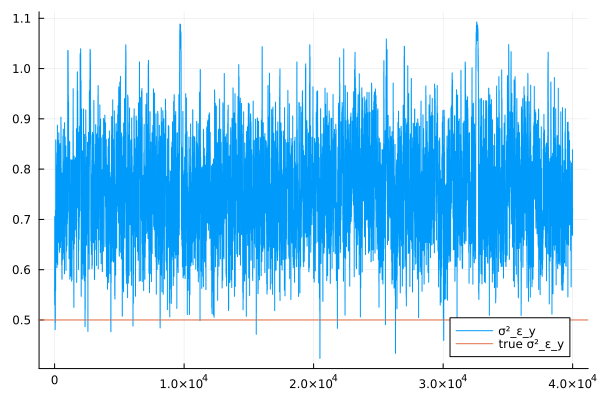

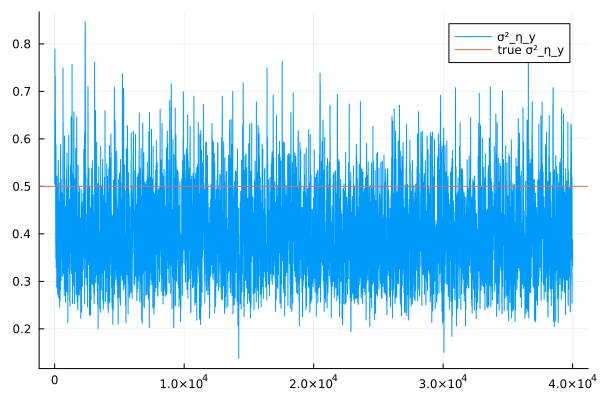

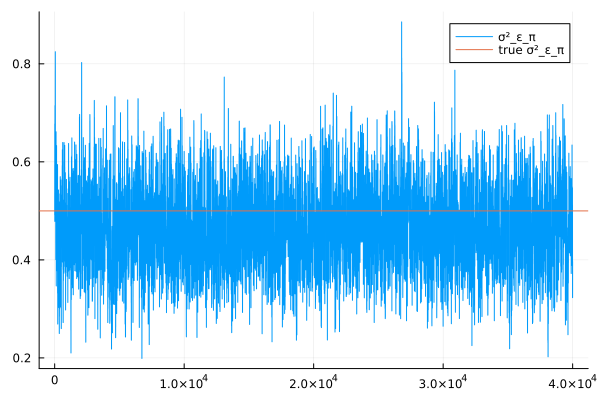

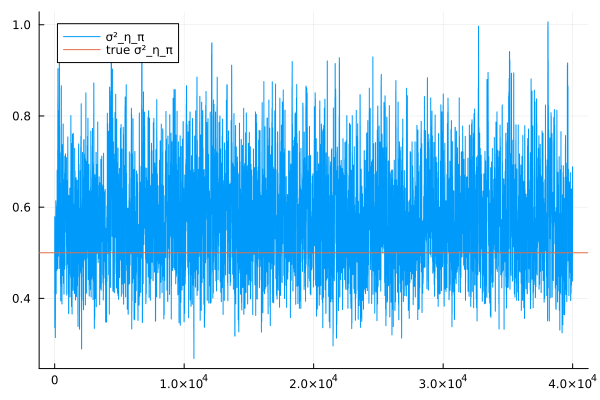

Initial chain shape: (40000, 4)


In [6]:
println("Initial chain shape: ", size(θ_chain_init))
#Print trace plot and add true value
for i in 1:size(θ_chain_init, 2)
    plot(θ_chain_init[:,i], label="$(θ_elements[i])")
    hline!([θ_true[i]], label="true $(θ_elements[i])")
    display(plot!())
end

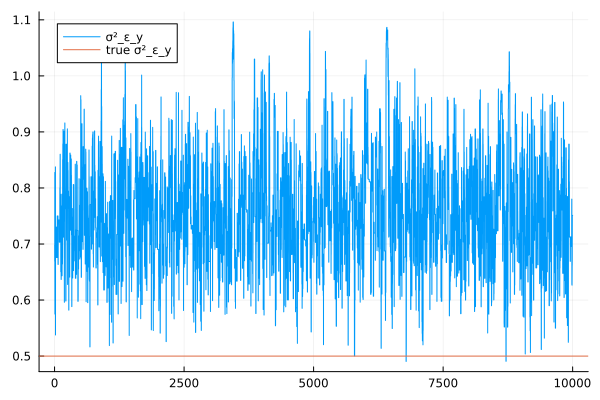

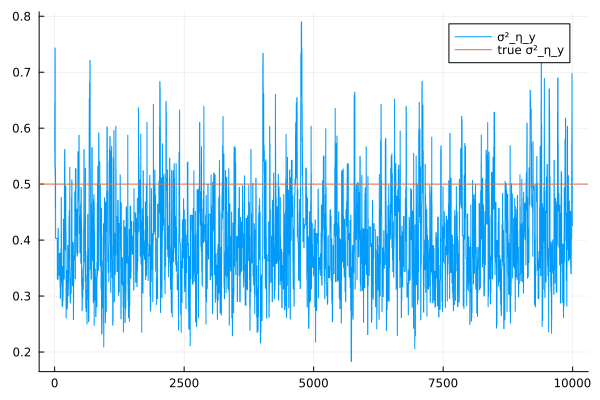

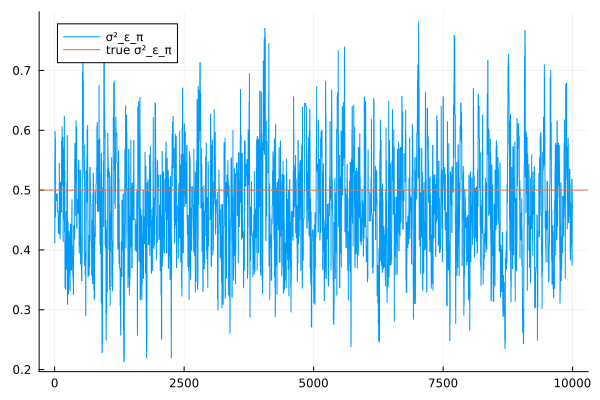

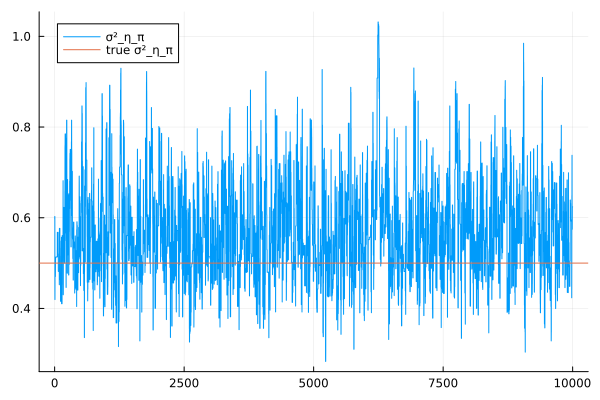

Rec chain shape: (10000, 4)


In [7]:
println("Rec chain shape: ", size(θ_chain))

#Print trace plot and add true value
for i in 1:size(θ_chain, 2)
    plot(θ_chain[:,i], label="$(θ_elements[i])")
    hline!([θ_true[i]], label="true $(θ_elements[i])")
    display(plot!())
end



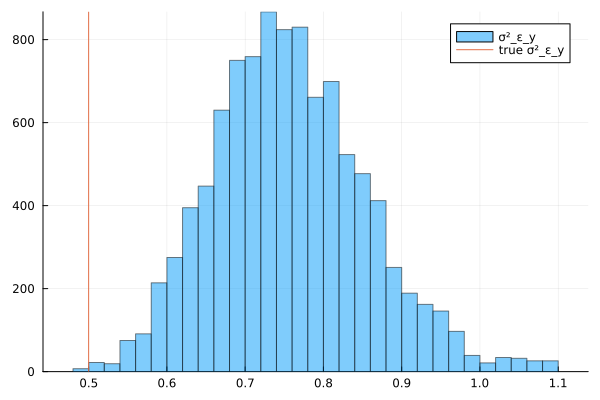

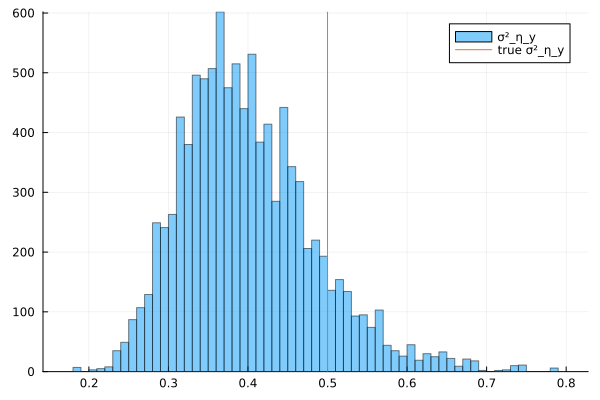

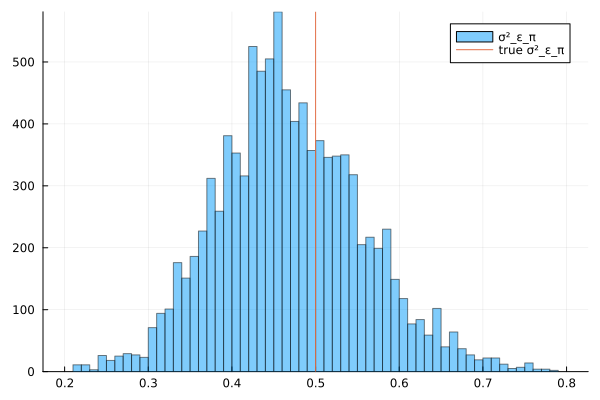

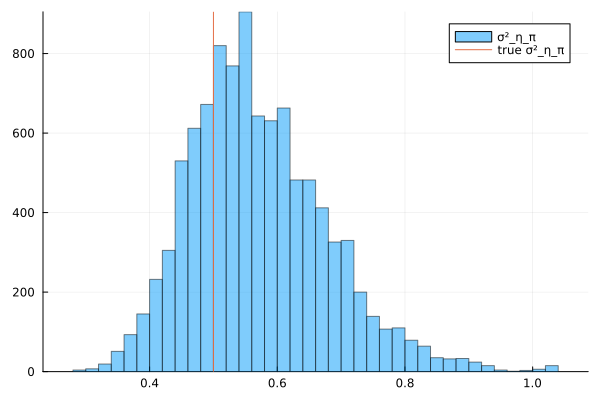

In [8]:
# plot histograms of the chains and add line at true value
for i in 1:size(θ_chain, 2)
    histogram(θ_chain[:,i], label="$(θ_elements[i])", alpha=0.5)
    vline!([θ_true[i]], label="true $(θ_elements[i])")
    display(plot!())
end

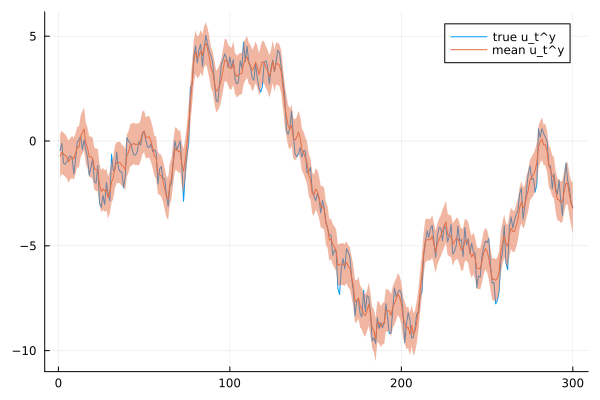

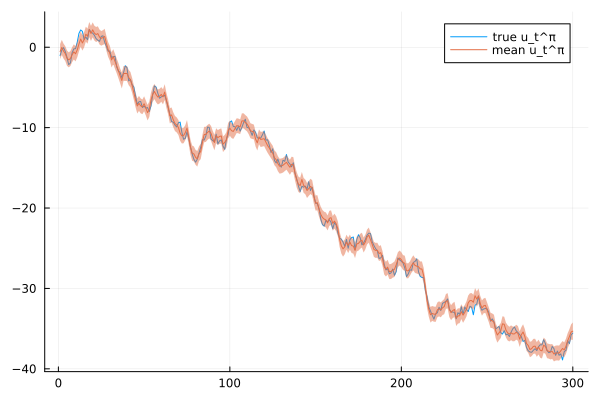

Mean of α_draws: (1, 2, 300)


BoundsError: BoundsError: attempt to access 2×300 Matrix{Float64} at index [3, 1:300]

In [9]:
# Compute the mean over iterations (dimension 1)
α_mean = mean(α_draws, dims=1)
println("Mean of α_draws: ", size(α_mean))

# Compute the 2.5% and 97.5% quantiles 
α_ci = mapslices(x -> quantile(x, [0.025, 0.975]), α_draws, dims=1)



# Plot true states, mean of states, and confidence intervals of states
for i in 1:size(α_mean, 3)
    plot(α[i,:], label="true $(α_elements[i])")
    plot!(α_mean[1, i,:], ribbon=(α_ci[2, i,:] .- α_mean[1, i,:]), label="mean $(α_elements[i])")
    display(plot!())
end


## MLE

In [10]:
using Optim


lower_bounds = [0.0, 0.0, 0.0, 0.0]
upper_bounds = [1.0, 1.0, 1.0, 1.0]
θ_init = θ_true 
objective(θ) = neg_log_likelihood(θ, obs, α0, P0, cycle_order, σʸ)
res = optimize(objective, lower_bounds, upper_bounds, θ_init, Fminbox(BFGS()))

# Extract the estimated parameters
θ_est = Optim.minimizer(res)

# Print the results:
println("\nMLE Results (with bounded optimization):")
for (i, param_name) in enumerate(θ_elements)
    println("Estimated $(param_name): $(θ_est[i])   (True value: $(θ_true[i]))")
end
println("\nFinal negative log-likelihood: ", Optim.minimum(res))



MLE Results (with bounded optimization):
Estimated σ²_ε_y: 0.9999999999999999   (True value: 0.5)
Estimated σ²_η_y: 0.9999999999999999   (True value: 0.5)
Estimated σ²_ε_π: 0.6723413007620126   (True value: 0.5)
Estimated σ²_η_π: 0.7955276911304574   (True value: 0.5)

Final negative log-likelihood: 955.6153642837005
